In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import time


#### Input Processing

In [2]:
FILE = "/mnt/d/446Project/WeatherTransformer/data_processing/generated_population_infused"
KFOLD = 5

def load_training_data(file = FILE):

    df = pd.read_csv(file, index_col=0)
    # df.to_csv("/mnt/d/446Project/WeatherTransformer/data_processing/generated_population_infused", index=False, encoding="utf-8")
    print(df.columns.tolist())
    df = df.loc[:, ~df.columns.str.contains("latitude|longitude|date|tude", case=False)]

    # df = df.drop(columns=["LONGITUDE"])

    df["FIRE"] = df["FIRE"].astype(float)

    # Identify and clean number-like strings with commas
    for col in df.columns:
        if df[col].dtype == 'object':
            # Remove commas and convert to float if possible
            try:
                df[col] = df[col].str.replace(",", "").astype(float)
            except:
                print("exception: likely categorical, leave it for one-hot encoding")
                pass

    label = df["FIRE"].values.astype(np.float32)
    features = df.drop(columns=["FIRE"])
    print("\n Features used for training:")
    print(features.columns.tolist())
    print(f"\n Target to predict: 'FIRE'\n")


    # One-hot encode remaining categorical columns (if any)
    features = pd.get_dummies(features)

    # Scale features
    scaler = MinMaxScaler()
    features_scaled = scaler.fit_transform(features)
    X = torch.tensor(features_scaled, dtype=torch.float32)
    y = torch.tensor(label, dtype=torch.float32)

    # Cross-validation
    skf = StratifiedKFold(n_splits=KFOLD, shuffle=True, random_state=42)

    return X, y, skf

X, y, skf = load_training_data()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


['LATITUDE', 'LONGITUDE', 'START_DATE', 'FUEL_TYPE', 'FIRE', 'Date', 'Spd of Max Gust (km/h)', 'Total Precip (mm)', 'Mean Temp (°C)', 'Min Temp (°C)', 'Max Temp (°C)', 'Distance to Weather Station (km)', 'dist_to_urban_deg', 'urban_type', 'urban_population_density', 'urban_dwelling', 'dist_to_urban_km']
exception: likely categorical, leave it for one-hot encoding
exception: likely categorical, leave it for one-hot encoding
exception: likely categorical, leave it for one-hot encoding

 Features used for training:
['FUEL_TYPE', 'Spd of Max Gust (km/h)', 'Total Precip (mm)', 'Mean Temp (°C)', 'Min Temp (°C)', 'Max Temp (°C)', 'Distance to Weather Station (km)', 'dist_to_urban_deg', 'urban_type', 'urban_population_density', 'urban_dwelling', 'dist_to_urban_km']

 Target to predict: 'FIRE'



#### Logistic Regression

In [3]:
from sklearn.linear_model import LogisticRegression

def logistic_regression_model(X_train, X_test, y_train, y_test):
    # Initialize the Logistic Regression model
    model = LogisticRegression(max_iter=1000)

    # Train the model
    model.fit(X_train, y_train)

    # Evaluate the model on the test data
    accuracy = model.score(X_test, y_test)
    print(f"Accuracy: {accuracy:.2f}")

    return model, accuracy

accuracies = []
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model, acc = logistic_regression_model(X_train, X_test, y_train, y_test)
    accuracies.append(acc)

# Report
print(f"{KFOLD}-fold cross-validation accuracies: {accuracies}")
print(f"Average accuracy: {np.mean(accuracies):.4f}")

Accuracy: 0.91
Accuracy: 0.91
Accuracy: 0.91
Accuracy: 0.91
Accuracy: 0.91
5-fold cross-validation accuracies: [0.9096007918178819, 0.909317999717208, 0.9094122637507659, 0.9094593957675449, 0.9095536598011029]
Average accuracy: 0.9095


#### Decision Tree

In [4]:
from sklearn.tree import DecisionTreeClassifier

def decision_tree_model(X_train, X_test, y_train, y_test):
    # Initialize the Decision Tree Classifier
    # set min_samples_split to 100 to avoid overfitting and limit iteration
    clf = DecisionTreeClassifier(min_samples_split=100, criterion='entropy', 
                                max_depth=7,random_state=42)

    # train the model
    clf.fit(X_train, y_train)

    # Evaluate the model on the test data
    accuracy = clf.score(X_test, y_test)
    print(f"Accuracy: {accuracy:.2f}")

    return clf, accuracy

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model, acc = decision_tree_model(X_train, X_test, y_train, y_test)
    accuracies.append(acc)

# Report
print(f"{KFOLD}-fold cross-validation accuracies: {accuracies}")
print(f"Average accuracy: {np.mean(accuracies):.4f}")

Accuracy: 0.91
Accuracy: 0.91
Accuracy: 0.91
Accuracy: 0.91
Accuracy: 0.91
5-fold cross-validation accuracies: [0.9096007918178819, 0.909317999717208, 0.9094122637507659, 0.9094593957675449, 0.9095536598011029, 0.9106376961870198, 0.9109676203044729, 0.9121930527407268, 0.9112975444219258, 0.9118631286232738]
Average accuracy: 0.9104


#### FCNN


🧾 Fold 1 Class Distribution:
Train: {0.0: 77189, 1.0: 7679}
Test : {0.0: 19297, 1.0: 1920}
>>> Fold 1 | Epoch 1 | Avg Epoch Loss: 0.2992 | Test Acc: 0.9095
>>> Fold 1 | Epoch 2 | Avg Epoch Loss: 0.2618 | Test Acc: 0.9096
saved torch checkpoints in fire_model_fold_1743759588.306238.pt

🧾 Fold 2 Class Distribution:
Train: {0.0: 77189, 1.0: 7679}
Test : {0.0: 19297, 1.0: 1920}
>>> Fold 2 | Epoch 1 | Avg Epoch Loss: 0.2953 | Test Acc: 0.9095
>>> Fold 2 | Epoch 2 | Avg Epoch Loss: 0.2602 | Test Acc: 0.9095
saved torch checkpoints in fire_model_fold_1743759603.442494.pt

🧾 Fold 3 Class Distribution:
Train: {0.0: 77189, 1.0: 7679}
Test : {0.0: 19297, 1.0: 1920}
>>> Fold 3 | Epoch 1 | Avg Epoch Loss: 0.2995 | Test Acc: 0.9095
>>> Fold 3 | Epoch 2 | Avg Epoch Loss: 0.2633 | Test Acc: 0.9095
saved torch checkpoints in fire_model_fold_1743759618.1782162.pt

🧾 Fold 4 Class Distribution:
Train: {0.0: 77189, 1.0: 7679}
Test : {0.0: 19297, 1.0: 1920}
>>> Fold 4 | Epoch 1 | Avg Epoch Loss: 0.3026 | T

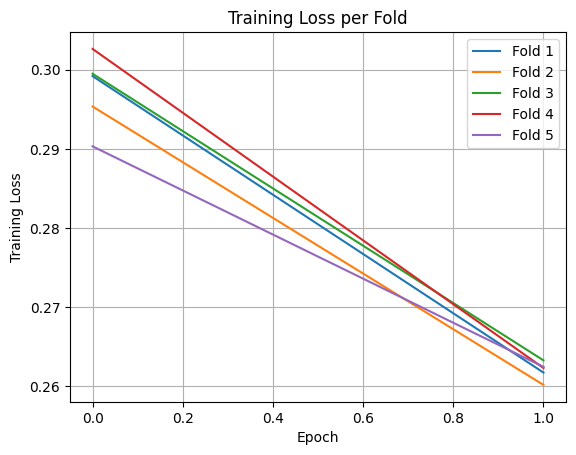

In [8]:
class FireClassifier(nn.Module):
    def __init__(self, input_size):
        super(FireClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    train_classes, train_counts = torch.unique(y_train, return_counts=True)
    test_classes, test_counts = torch.unique(y_test, return_counts=True)

    print(f"\n🧾 Fold {fold+1} Class Distribution:")
    print(f"Train: {dict(zip(train_classes.tolist(), train_counts.tolist()))}")
    print(f"Test : {dict(zip(test_classes.tolist(), test_counts.tolist()))}")

    # Create DataLoaders
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32)

    # Model, loss, optimizer
    model = FireClassifier(input_size=X.shape[1]).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop with loss tracking
    model.train()
    num_epochs = 2
    train_losses = []
    test_accuracies = []

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        batch_count = 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device).view(-1, 1)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

            batch_loss = loss.item()
            epoch_loss += batch_loss * xb.size(0)
            batch_count += 1

            # Per-batch loss
            # print(f"Fold {fold+1} | Epoch {epoch+1} | Batch {batch_count} | Batch Loss: {batch_loss:.4f}")

        avg_loss = epoch_loss / len(train_loader.dataset)
        train_losses.append(avg_loss)

        # === Evaluation on test set ===
        model.eval()
        all_preds = []
        with torch.no_grad():
            for xb, _ in test_loader:
                xb = xb.to(device)
                preds = model(xb)
                all_preds.extend(preds.cpu().numpy())

        binary_preds = (np.array(all_preds) > 0.5).astype(int).flatten()
        test_acc = accuracy_score(y_test.numpy(), binary_preds)
        test_accuracies.append(test_acc)

        print(f">>> Fold {fold+1} | Epoch {epoch+1} | Avg Epoch Loss: {avg_loss:.4f} | Test Acc: {test_acc:.4f}")

    # Plot loss for this fold
    plt.plot(train_losses, label=f"Fold {fold+1}")


    # Evaluation
    model.eval()
    all_preds = []
    with torch.no_grad():
        for xb, _ in test_loader:
            xb = xb.to(device)
            preds = model(xb)
            all_preds.extend(preds.cpu().numpy())
    
    binary_preds = (np.array(all_preds) > 0.5).astype(int).flatten()
    acc = accuracy_score(y_test.numpy(), binary_preds)
    accuracies.append(acc)

    torch.save(model.state_dict(), f"/mnt/d/446Project/WeatherTransformer/FCNN_model/fcnn_checkpoints/fire_model_fold_{time.time()}.pt")
    print(f"saved torch checkpoints in fire_model_fold_{time.time()}.pt")
    # model.load_state_dict(torch.load("fire_model_fold_2.pt"))

# Report
print(f"{KFOLD}-fold cross-validation accuracies: {accuracies}")
print(f"Average accuracy: {np.mean(accuracies):.4f}")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss per Fold")
plt.legend()
plt.grid(True)
plt.show()
